# SciML SANUM2024
# Lab 5: Neural Networks and Lux.jl

In this lab we introduce neural networks as implemented in Lux.jl.
A neural network (NN) is in some sense just a function with many parameters
in a way that facilitates computing gradients with respect to these parameters.
That is: it is at its core a way of book-keeping a heavily parameterised function.
It is constructed by composing basic building blocks usually built from linear
algebra operations, combined with simple _activator functions_.
Here we look at the simplest case and see how the paremeters in a NN can be chosen to
solve optimisation problems. In other words: we will _train_ the NN.

**Learning Outcomes**
1. Single-layer neural networks and activation functions.
2. Creating deeper networks as a `Chain`.
3. Training neural networks by simple optimisation.

In [45]:
using Lux, Random, Optimization, OptimizationOptimisers, ComponentArrays, Zygote, Plots, LinearAlgebra, Test

## 4.1 Single layer neural networks

We begin with a single-layer NN without an activator
function which correspond to maps of the form:
$$
𝐱 ↦ A𝐱 + 𝐛
$$
where $A ∈ ℝ^{m × n}$ and $𝐛 ∈ ℝ^n$. The space of such maps is
modelled by the `Dense` type which has two paramters: `weight`, corresponding to $A$, and
 `bias`, corresponding to $𝐛$. Here we see a simple example
of constructing the model (the space of all such maps) and evaluating
a specific map by specifying the parameters.

Note we have to pass an extra argument corresponding to
the "state" of a NN: this doesn't exist for the simple layers we consider
but more sophisticated NNs can depend on history and so the state records the relevant
information.

In [46]:
m,n = 5,4

model = Dense(n => m) # represents maps of the form 𝐱 ↦ A𝐱 + 𝐛

A = randn(5,4)
b = randn(5)
x = randn(4)
const NOSTATE = NamedTuple() # no state for our NN
val,newst = model(x, (weight=A, bias=b), NOSTATE) # returns the output of the map and the updated state, which we ignore


@test val == A*x + b # our model with these parameters is just A*x + b

Test Passed

An important feature is that we can compute gradients with respect to parameters of functions of our
model. Before we looked at the case where
we differentiated with respect to vectors but a powerful feature in Zygote is it works for other types, including the `NamedTuple`
which Lux.jl uses for representing paramaters:

In [47]:
ps = (weight=A, bias=b) # parameters as a NamedTuple
ps_grad = gradient(p -> sum(model(x, p, NOSTATE)[1]), ps)[1] # returns a named tuple containing the gradients

(weight = [0.27610785903233287 1.4513296128782116 1.04229991101404 -0.6220510416524787; 0.27610785903233287 1.4513296128782116 1.04229991101404 -0.6220510416524787; … ; 0.27610785903233287 1.4513296128782116 1.04229991101404 -0.6220510416524787; 0.27610785903233287 1.4513296128782116 1.04229991101404 -0.6220510416524787], bias = Fill(1.0, 5))

Because our NN at this stage is linear in the paremeters the gradient is actually quite simple: eg the partial derivative with
respect to $A[k,j]$ will just be $x[j]$ and the derivative with respect to $b[k]$ will just be $1$. Thus we get:

In [48]:
@test ps_grad[:weight] ≈ ones(5) * x'
@test ps_grad[:bias] ≈ ones(5)

Test Passed

Going beyond basic linear algebra, we can apply an "activator" function $f$ to each
entry of the map, to represent maps of the form:
$$
𝐱 ↦ f.(A𝐱 + 𝐛)
$$
where we use the Julia-like broadcast notation to mean entrywise application.
The classic activator is the `relu` function which is really just $\max(0,x)$:

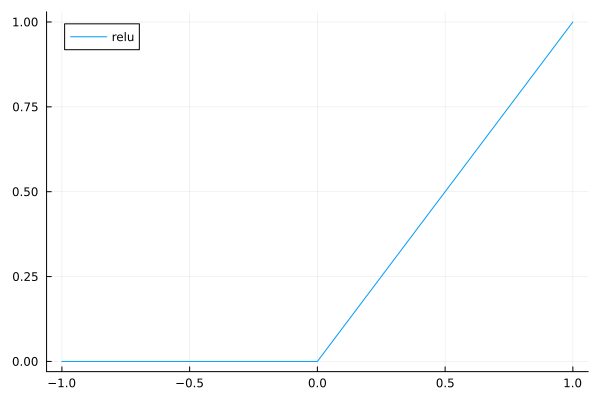

In [49]:
x = range(-1,1, 1000)
plot(x, relu.(x); label="relu")

We can incorporate this in our model as follows:

In [50]:
x = randn(4)
model = Dense(4 => 5, relu)
model(x, (weight = A, bias=b), NOSTATE)[1]

5-element Vector{Float64}:
 1.3954069085044898
 0.0
 0.0
 1.1861045114850892
 3.5190518696154642

And we can compute gradients as before:

In [51]:
ps = (weight=A, bias=b)
ps_grad = gradient(p -> sum(model(x, p, NOSTATE)[1]), ps)[1] # returns a named tuple containing the gradients

(weight = [1.1801975440522638 -0.266656788141034 -0.5971203777049628 -0.7159623534883142; 0.0 -0.0 -0.0 -0.0; … ; 1.1801975440522638 -0.266656788141034 -0.5971203777049628 -0.7159623534883142; 1.1801975440522638 -0.266656788141034 -0.5971203777049628 -0.7159623534883142], bias = [1.0, 0.0, 0.0, 1.0, 1.0])

**Problem 1** Derive the formula  for the gradient of the model with an activator function and compare it with
the numerical result just computed. Hint: The answer depends on the output value.

In [52]:
## TODO: Compute the gradient by hand, matching ps_grad
# SOLUTION
# We just need to filter by the sign of the output:
s = (1 .+ sign.(A*x + b))/2

@test ps_grad[:weight] ≈ s * x'
@test ps_grad[:bias] ≈ s

# END

Test Passed

Let's see an example directly related to a classic numerical analysis problem: approximating
functions by a continuous piecewise affine
function, as done in the Trapezium rule. Our model corresponds to a sum of weighted and shifted `relu` functions:
$$
p_{𝐚,𝐛}(x) := ∑_{k=1}^n {\rm relu}(a_k x + b_k)
$$
We note that this is a sum of positive convex functions so will only be useful for approximating positive convex functions
(we will generalise this later).  Thus we want to choose the paremeters to fit data generated by a positive convex function,
e.g., $f(x) = \exp(x)$. Here we first generate "training data" which means the samples of the function on a grid.

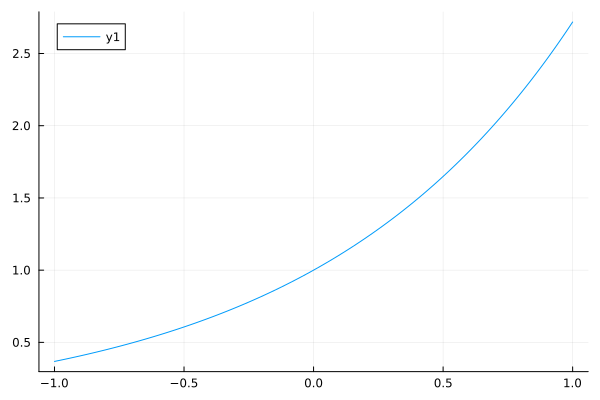

In [53]:
n = 100
x = range(-1, 1; length = n)
y = exp.(x)
plot(x, y)

Our one-layer NN (before the summation) is
$$
  {\rm relu}.(𝐚x + 𝐛)
$$
which corresponds to a simple dense layer with `relu` activation.
We then sum over the output of this to get the model
$$
  [1,…,1]^⊤ {\rm relu}.(𝐚x + 𝐛)
$$
In our case `x` is actually a vector containing the grid we sample on
but we first need to transpose it to be a $1 × n$ matrix, which will apply the NN
to each grid point. We can then sum over the columns to get the value of the model with the given
parameters at the grid points.

In [54]:
nn = Dense(1 => n, relu)
function summation_model(ps, (nn, x))
    Y,st = nn(x', ps, NOSTATE) # k-th column contains relu.(𝐚x[k] + 𝐛)
    vec(sum(Y; dims=1)) # sums over the columns
end

summation_model (generic function with 1 method)

We want to choose the parameters to minimise a loss function. Here we
just wish to minimise the 2-norm error which we can write as follow:

In [55]:
function convex_regression_loss(ps, (nn, (x,y)))
    ỹ = summation_model(ps, (nn, x))
    norm(ỹ - y) # 2-norm error
end

convex_regression_loss (generic function with 1 method)

We now setup the optimation problem. We can use `Lux.setup` to create a random initial guess for parameters
though we need to supply a random number generator. We also need to wrap the returned named tuple in a `ComponentArray` as Optimization.jl
requires the optimisation to be over an array-type.

  0.200557 seconds (635.50 k allocations: 206.695 MiB, 6.58% gc time, 79.66% compilation time: 74% of which was recompilation)


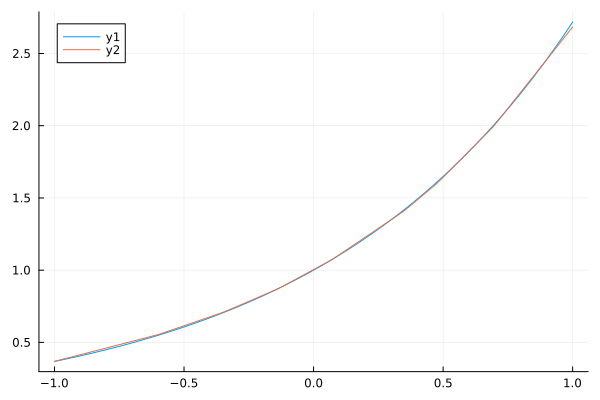

In [56]:
rng = MersenneTwister() # Random number generator.
ps = ComponentArray(Lux.setup(rng, nn)[1])

prob = OptimizationProblem(OptimizationFunction(convex_regression_loss, Optimization.AutoZygote()), ps, (nn, (x, y)))
@time ret = solve(prob, Adam(0.03), maxiters=250)

plot(x, y)
plot!(x, summation_model(ret.u, (nn, x)))

**Problem 2**  Replace `relu` in the activation function with a smooth `tanh` function and plot
the result. Is the approximation as accurate? What if you increase the number of epochs?
What if you construct your own function that is a smooth approximation to `relu`?

  0.273907 seconds (636.76 k allocations: 206.761 MiB, 2.96% gc time, 77.47% compilation time: 69% of which was recompilation)


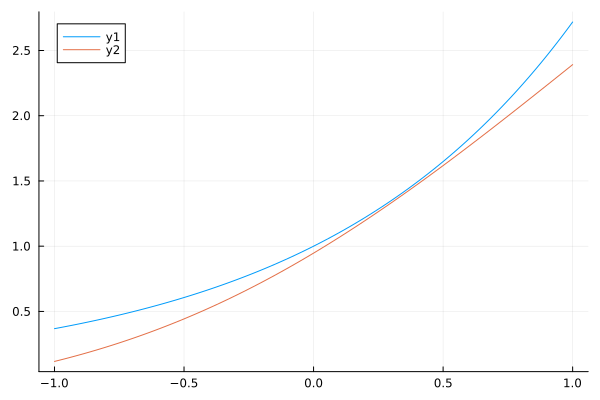

In [57]:
# TODO: setup a neural network with different activations
# SOLUTION

nn = Dense(1 => n, tanh)
ps = ComponentArray(Lux.setup(rng, nn)[1])
prob = OptimizationProblem(OptimizationFunction(convex_regression_loss, Optimization.AutoZygote()), ps, (nn, (x, y)))
@time ret = solve(prob, Adam(0.03), maxiters=250)

plot(x, y)
plot!(x, summation_model(ret.u, (nn, x))) # much less accurate

  0.245750 seconds (315.52 k allocations: 720.441 MiB, 8.30% gc time)


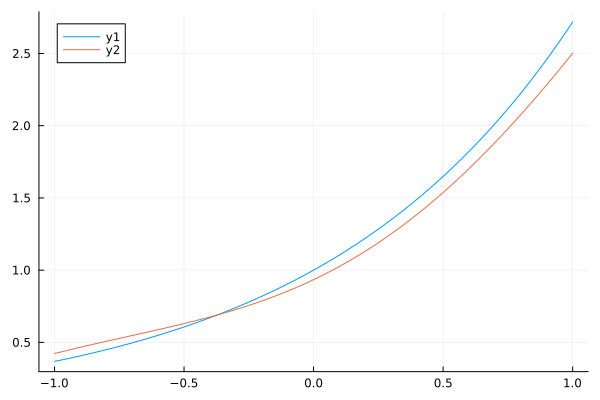

In [58]:
@time ret = solve(prob, Adam(0.03), maxiters=1000)

plot(x, y)
plot!(x, summation_model(ret.u, (nn, x))) # still not accurate

We can use the following smooth step:

  1.233351 seconds (2.97 M allocations: 1.847 GiB, 5.27% gc time, 55.06% compilation time)


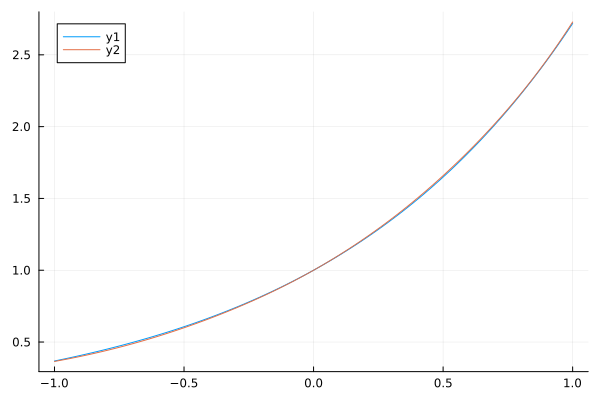

In [59]:
smoothstep = x -> x*(tanh(10x) + 1)/2
plot(x,smoothstep.(x))

nn = Dense(1 => n, smoothstep)
ps = ComponentArray(Lux.setup(rng, nn)[1])
prob = OptimizationProblem(OptimizationFunction(convex_regression_loss, Optimization.AutoZygote()), ps, (nn, (x, y)))
@time ret = solve(prob, Adam(0.03), maxiters=2000)

plot(x, y)
plot!(x, summation_model(ret.u, (nn, x))) # much more accurate than other results.


# END

## 4.2 Multiple layer neural networks

An effective NN will have more than one layer. A simple example is if we want to go beyond
convex functions. Rather than simply summing over the NN we can allow different weights,
giving us the model
$$
  𝐜^⊤ {\rm relu}.(𝐚x + 𝐛) + d.
$$
Or we can think of $C = 𝐜^⊤$ as a $1 × n$ matrix. This is in fact a composition of two simple layers, the first being
$$
 x ↦ {\rm relu}.(𝐚x + 𝐛)
$$
and the second being one without an activation function:
$$
 𝐱 ↦ C 𝐱 + d.
$$
I.e., they are both `Dense` layers just with different dimensions and different activation functions (`relu` and `identity`).
We can create such a composition using the `Chain` command:

In [60]:
n = 100
model = Chain(Dense(1 => n, relu), Dense(n => 1))

Chain(
    layer_1 = Dense(1 => 100, relu),    # 200 parameters
    layer_2 = Dense(100 => 1),          # 101 parameters
)         # Total: 301 parameters,
          #        plus 0 states.

Here the parameters are nested. For example, we can create the relevant parameters as follows:

In [61]:
𝐚,𝐛 = randn(n,1),randn(n)
𝐜,d = randn(n),randn(1)

st = (layer_1 = NOSTATE, layer_2 = NOSTATE) # each layer has its own state
ps = (layer_1 = (weight = 𝐚, bias = 𝐛), layer_2 = (weight = 𝐜', bias = d))

@test model([0.1], ps, st)[1] ≈ 𝐜'*relu.(𝐚*0.1 + 𝐛) + d

Test Passed

We can plot the model evaluated at the gri to see that it is indeed (probably) no longer convex:

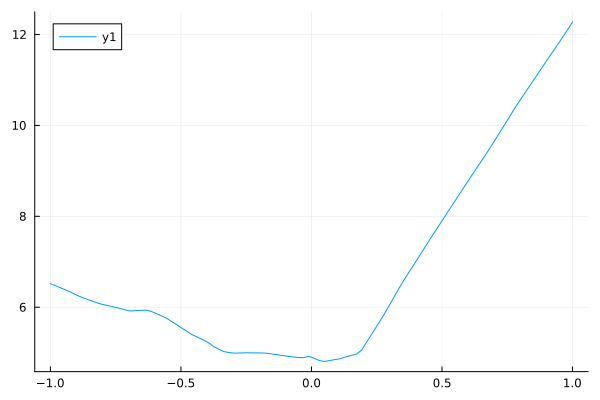

In [62]:
plot(x, vec(model(x', ps, st)[1]))

We now choose the parameters to fit data. Let's generate data for a non-convex function:

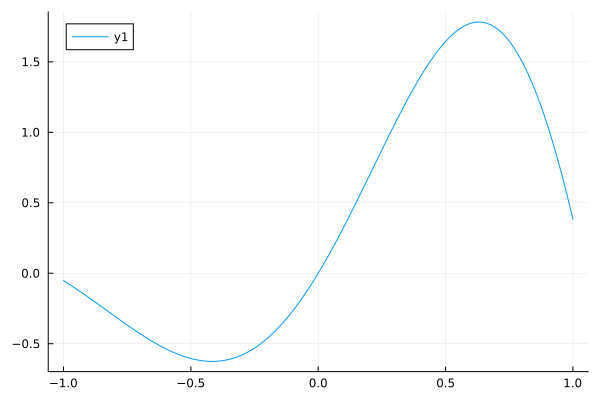

In [63]:
x = range(-1, 1; length = n)
y = sin.(3x).*exp.(x)
plot(x,y)

We will fit this data by minimising the 2-norm with a different model:

  0.119625 seconds (388.52 k allocations: 205.068 MiB, 10.09% gc time, 60.22% compilation time: 89% of which was recompilation)


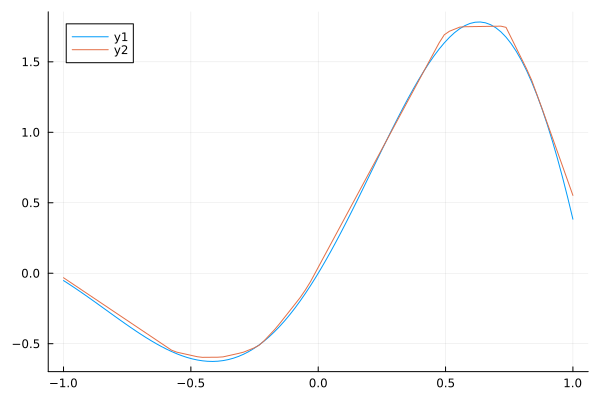

In [64]:
function regression_loss(ps, (model, st, (x,y)))
    ỹ = vec(model(x', ps, st)[1])
    norm(ỹ - y) # 2-norm error
end

ps,st = Lux.setup(rng, model)
prob = OptimizationProblem(OptimizationFunction(regression_loss, Optimization.AutoZygote()), ComponentArray(ps), (model, st, (x, y)))
@time ret = solve(prob, Adam(0.03), maxiters=250)

plot(x,y)
plot!(x, vec(model(x', ret.u, st)[1]))

 It does OK but is still not particularly impressive. The real power in neural networks is their approximation power
increases as we add more layers. Here let's try an example with 3-layers.

  1.644892 seconds (820.81 k allocations: 6.201 GiB, 8.79% gc time, 4.77% compilation time: 89% of which was recompilation)


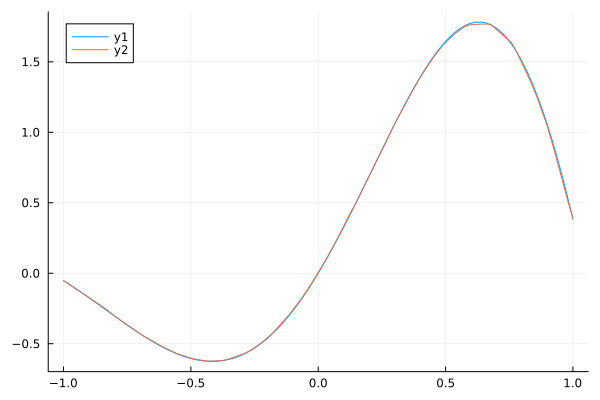

In [65]:
model = Chain(Dense(1 => 200, relu), Dense(200 => 200, relu), Dense(200 => 1))

ps,st = Lux.setup(rng, model)
prob = OptimizationProblem(OptimizationFunction(regression_loss, Optimization.AutoZygote()), ComponentArray(ps), (model, st, (x, y)))
@time ret = solve(prob, Adam(0.03), maxiters=1000)

plot(x,y)
plot!(x, vec(model(x', ret.u, st)[1]))

**Problem 3** Add a 4th layer and 5th layer, but not all involving square matrices.
Can you choose the size of the layers and the activation functions to
match the eyeball norm? Hint: the answer might be "no" 😅 But maybe "ballpark norm" is sufficient.

  0.705923 seconds (923.36 k allocations: 2.147 GiB, 10.41% gc time, 12.94% compilation time: 87% of which was recompilation)
  0.422659 seconds (990.40 k allocations: 1.367 GiB, 14.63% gc time, 19.34% compilation time: 91% of which was recompilation)
  3.810522 seconds (6.19 M allocations: 4.867 GiB, 5.62% gc time, 60.29% compilation time)


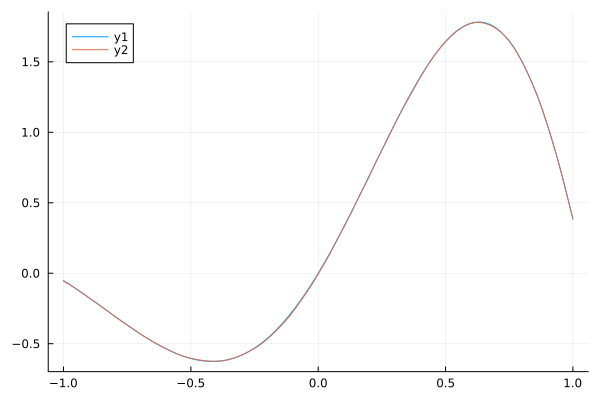

In [66]:
# SOLUTION

model = Chain(Dense(1 => 100, relu), Dense(100 => 50, relu), Dense(50 => 50, relu), Dense(50 => 1))
ps,st = Lux.setup(rng, model)
prob = OptimizationProblem(OptimizationFunction(regression_loss, Optimization.AutoZygote()), ComponentArray(ps), (model, st, (x, y)))
@time ret = solve(prob, Adam(0.03), maxiters=1000)

plot(x,y)
plot!(x, vec(model(x', ret.u, st)[1]))

#
model = Chain(Dense(1 => 30, relu), Dense(30 => 30, relu), Dense(30 => 40, relu), Dense(40 => 30, relu), Dense(30 => 1))
ps,st = Lux.setup(rng, model)
prob = OptimizationProblem(OptimizationFunction(regression_loss, Optimization.AutoZygote()), ComponentArray(ps), (model, st, (x, y)))
@time ret = solve(prob, Adam(0.03), maxiters=1000)

plot(x,y)
plot!(x, vec(model(x', ret.u, st)[1]))

#

model = Chain(Dense(1 => 30, smoothstep), Dense(30 => 30, smoothstep), Dense(30 => 40, smoothstep), Dense(40 => 30, smoothstep), Dense(30 => 1))

ps,st = Lux.setup(rng, model)
prob = OptimizationProblem(OptimizationFunction(regression_loss, Optimization.AutoZygote()), ComponentArray(ps), (model, st, (x, y)))
@time ret = solve(prob, Adam(0.02), maxiters=3000)

plot(x,y)
plot!(x, vec(model(x', ret.u, st)[1])) # Just about achieves eyeball norm.

# END

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*